In [1]:
import enum
import random

import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np

import copy

In [2]:
# cooperate => True
# defect => False

## *Uvod*

*Game theory* (Teorija igara) je oblast koja se bavi proučavanjem međusobnog uticaja i dejstva "igara". U toku igre, igrači (*u našem slučaju postoje 2 igrača*), pokušavaju jedan drugog da nadmudre primenom određenih strategija. 

Igra koju mi razmatramo je **prisoners dillema** (zatvorenikova dilema), u kojoj igrači u isto vreme daju jednu od dve opcije:
    
    -  Cooperate (Da sarađuje sa drugim igračem) 
    -  Defect (Da ne sarađuje sa drugim igračem) 
U zavisnosti od toga koju su opciju izabrali, kao i koju je opciju izabrao protivnik, dobiće neki broj bodova. Matrica bodova koje dobijaju:

| * | Cooperate | Defect |
| --- | --- | --- |
| **Cooperate** | (R, R) | (S, T) |
| **Defect** | (T, S) | (P, P) |

*Npr.* ako igrač 1. stavi Cooperate, a igrač 2. Defect, igrač 1. će dobiti S bodova, a 2. T bodova. Vrednost R, S, T i P se određuju na samom početku partije, i obično će ***vrednosti za R i S pozivitine (ali izabrane tako da R < T), S biti negativne, za P ćemo uzeti 0***.

Oba igrača dobijaju neku početnu sumu bodova (*SS u daljem radu*), i ako njihova suma postane **<= 0**, oni su izgubili partiju. Pored toga, postoji i maksimalna suma bodova (*MS u daljem radu*), i suma igrača ne sme preći tu vrednost.

## Strategije

Kao rezultat svega ovoga, formiraju se *strategije*, koje će igračima pomoći da budu u prednosti u odnosu na protivnika. Postoji velika količina različitih strategija, ali one koje su korišćene u radu su:
    
    1. Defactor (D) - Uvek radi Defect akciju
    2. Cooperator (C) - Uvek radi Cooperate akciju
    3. Tit-for-tat (TFT) - Prvi potez će mu uvek biti Cooperate, ali svaki sledeći će mu biti akcija koju je prethodni protivnik iskoristio
    4. Anti-tit-for-tat (ATFT) - Prvi potez će mu uvek biti Defect, ali svaki sledeći će mu biti suprotna akcija od one koju je prethodni protivnik iskoristio

In [3]:
class TypeOfStrategy(enum.Enum):
    Defactor = 1
    Cooperator = 2
    Tit_for_tat = 3
    Anti_tit_for_tat = 4
    
def chr2strategy(strategy):
    if strategy == 'D':
        return TypeOfStrategy.Defactor
    if strategy == 'C':
        return TypeOfStrategy.Cooperator
    if strategy == 'T':
        return TypeOfStrategy.Tit_for_tat
    if strategy == 'A':
        return TypeOfStrategy.Anti_tit_for_tat
    return None

def strategy2chr(strategy):
    if strategy == TypeOfStrategy.Defactor:
        return 'D'
    if strategy == TypeOfStrategy.Cooperator:
        return 'C'
    if strategy == TypeOfStrategy.Tit_for_tat:
        return 'T'
    if strategy == TypeOfStrategy.Anti_tit_for_tat:
        return 'A'
    return None

Pravimo klasu *Strategy*, koja nam zapravo predstavlja neku od mogućih strategija, i koja ima metod *next_move*, koja će nam dati sledeći potez igrača.

In [4]:
# strategija bira uz pomoc next_move koju ce vrednost nas igrac dati (tj. da li ce coop ili defect)
class Strategy:    
    
    def __init__(self, type_of_strategy):
        self.type_of_strategy = type_of_strategy
        self.previous_move = None
        
    def next_move(self):      
        if self.type_of_strategy == TypeOfStrategy.Cooperator:
            return True
        if self.type_of_strategy == TypeOfStrategy.Defactor:
            return False
        if self.type_of_strategy == TypeOfStrategy.Tit_for_tat:
            if self.previous_move == None:
                return True
            return self.previous_move
        if self.type_of_strategy == TypeOfStrategy.Anti_tit_for_tat:
            if self.previous_move == None:
                return False
            return not self.previous_move 
        
    
    def update_previous_move(self, new_move):
        self.previous_move = new_move
        
    def __str__(self):
        return f"Stg({strategy2chr(self.type_of_strategy)})"

## Igranje igre

Po pitanju formiranja igre, imaćemo *n * n* matricu, gde će svaka ćelija predstavljati jednog igrača, sa svojom strategijom i rezultatom. U toku jedne runde, svaki igrač će izabrati jednog od njegovih suseda (u matrici), da odigraju jednu rundu, i nakon nje, oba igrača će dobiti/izgubiti određenu količinu bodova. Tako će se igra izvršavati, kroz više iteracija, da bismo pratili šta se vremenom dešava (koje su strategije bolje/gore i slično).

*Primer jedne takve matrice* (u ovom slučaju, crveni predstavljaju igrače koji koriste strategiju Defect, a zeleni TFT):

<img src="../results/example_1.png">

## Smrt i mutacija

Sad se postavlja pitanje, šta se dešava ako rezultat nekog igrača bude **<= 0** ? Postoje dva slučaja:
    
    1. Klasična smrt
    2. Mutacija

Klasična smrt podrazumeva kada igraču bude rezultat <=0, ili kada se nešto drugo desi (ubrzo o tome), on će, pri smrti, uzeti nekog od njegovih komšija (*nasumično*), i iskopiraće sve njegove bitne podatke. Tj. imaće istu strategiju kao on, i takođe će kopirati njegov trenutni rezultat.

Mutacija podrazumeva da pri umiranju igrača, postoji vrlo mala verovatnoća da neće umreti na "klasičan način", već će izabrati neku strategiju (nasumično), i staviće rezultat na početnu sumu bodova (SS). Na nekim način, kao da se ta ćelija preporodila, i ne zavisi od komšija. 

Pored toga, postoji još jedan načim da igrač umre, **od starosti**. U toku igranja igre, posle svake iteracije povećavamo igraču broj godina. Verovatnoća da će igrač umreti od starosti je :
    


$$
\frac{\lambda}{\theta} + 1, \\
{\lambda} - {player age} \\
{\theta} - rate of senescence \\
$$

Ako je *rate of senescence = 10*, a naš igrač ima 19 godina, onda postoji 90% šanse da će umreti. Rate of senescence služi da bi se sprečilo umiranje velike količine igrača u isto vreme.

Sledeća klasa *Player*, nam zapravo predstavlja igrača, u kojoj se nalaze sve vrednosti koje smo spomiljali, kao što su rezultat, početni rezultat, broj godina, šansa da se dogodi mutacija, i slične. Pored njih, postoji i metoda koja će proveriti da li je igrač umro, i ako jeste, *izvršiti ili mutaciju, ili standarnu smrt*.

Podrazumevane vrednosti za mutaciju = 0, **jer u nekim slučajevima želimo da vidimo kako će igra prolaziti, ako ne postoji mutacija** (slično za rate_of_senescence, tj. da ne postoji umiranje od starosti).


In [5]:
class Player:
    # vrednosti kao rate_of_senescence i max_score su uvek iste, pa neka budu staticke
    rate_of_senescence = float('inf')
    maximum_score = 4
    starting_score = 2
    
    mutation_probability = 0.0
    starting_age = 0
    
    def __init__(self, type_of_strategy, i, j):
        self.strategy = Strategy(type_of_strategy)
        self.age = Player.starting_age
        self.score = Player.starting_score
        self.i = i
        self.j = j
     
    def check_death(self):
        chance_death_old_age = (self.age / Player.rate_of_senescence) - 1 
        if random.random() < chance_death_old_age or self.score <= 0:
            return True
        return False
    
    def reborn(self, neighbours):
        # moguci ishodi:
        # 1) kopira sve od random suseda
        # 2) mutacija => mala verovatnoca, uzima skroz random strategiju, i pocinje ispocetka
        if random.random() < Player.mutation_probability:
            self.mutation()
        else:
            selected_neighbour = random.choice(neighbours)
            self.strategy = Strategy(selected_neighbour.strategy.type_of_strategy)
            self.score = selected_neighbour.score
        self.age = 0
            
    def mutation(self):
        self.strategy = Strategy(TypeOfStrategy(random.randint(1, len(TypeOfStrategy))))
        self.age = Player.starting_age        
        self.score = Player.starting_score
        
    def __str__(self):
        return f"Ply({self.strategy}, Age({self.age}), Scr({self.score}))"


In [6]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

Klasa *Game* će predstavljati odigravanje onoliko rundi koliko je dato kao parametar. Unutar nje, postoji atribut *state* koje predstavlja naše stanje igre u nekoj iteraciji (npr. prethodna slika je pokazala stanje igre u prvoj iteraciji). Pored toga, *game* je odgovoran za interakcije između neka 2 igrača, kao i ažuriranje svega potrebnog posle.

In [7]:
class Game:
    Cooperate = True
    Defect = False
    
    def __init__(self, payoff_values, n=10, initial_state=None, num_of_iterations=10, mutation_rate=0.0, rate_of_senescence=float('inf')):
        self.payoff_matrix = self.__set_payoff_matrix(payoff_values)
        self.n = n if initial_state is None else len(initial_state)
        self.state = self.__process_initial_state(n, initial_state)
        self.all_states = []
        self.num_of_iterations = num_of_iterations
        self.strategy_counter = []
        # svaki put kad kreiramo igru, postavljamo staticku vrednost mut_rate za trenutni game (podrazumevano 0)
        Player.mutation_probability = mutation_rate
        Player.rate_of_senescence = rate_of_senescence
     
    def __set_payoff_matrix(self, payoff_values):
        return {
            (Game.Cooperate, Game.Cooperate) : (payoff_values["R"], payoff_values["R"]),
            (Game.Cooperate, Game.Defect) : (payoff_values["S"], payoff_values["T"]),
            (Game.Defect, Game.Cooperate) : (payoff_values["T"], payoff_values["S"]),
            (Game.Defect, Game.Defect) : (payoff_values["P"], payoff_values["P"])
        }
    
    def __process_initial_state(self, n, initial_state):
        state = []
        
        if initial_state is not None:
            state = [[Player(chr2strategy(strategy), i, j) for j, strategy in enumerate(row)] for i, row in enumerate(initial_state)]
        else:
            state = [[Player(TypeOfStrategy(random.randint(1, 4)), i, j) for j in range(n)] for i in range(n)]
        
        return state
    
    def __neighbours(self, i, j):
        neighbours = []
        if i > 0 and j > 0:
            neighbours.append(self.state[i-1][j-1])
        if i > 0:
            neighbours.append(self.state[i-1][j])
        if i > 0 and j < self.n - 1:
            neighbours.append(self.state[i-1][j+1])
        if j > 0:
            neighbours.append(self.state[i][j-1])
        if j < self.n - 1:
            neighbours.append(self.state[i][j+1])
        if i < self.n - 1 and j > 0:
            neighbours.append(self.state[i+1][j-1])
        if i < self.n - 1:
            neighbours.append(self.state[i+1][j])
        if i < self.n - 1 and j < self.n - 1:
            neighbours.append(self.state[i+1][j+1])
        return neighbours
    
    def __select_neighbour_index(self, i, j):
        indices = []
        if i > 0 and j > 0:
            indices.append((i-1, j-1))
        if i > 0:
            indices.append((i-1, j))
        if i > 0 and j < self.n - 1:
            indices.append((i-1, j+1))
        if j > 0:
            indices.append((i, j-1))
        if j < self.n - 1:
            indices.append((i, j+1))
        if i < self.n - 1 and j > 0:
            indices.append((i+1, j-1))
        if i < self.n - 1:
            indices.append((i+1, j))
        if i < self.n - 1 and j < self.n - 1:
            indices.append((i+1, j+1))
            
        index = random.randint(0, len(indices) - 1)
        
        return indices[index]
    
    def __players_interations(self, player1, player2, neighbours1, neighbours2):
        p1_move = player1.strategy.next_move()
        p2_move = player2.strategy.next_move() 
        player1.strategy.previous_move = p2_move
        player2.strategy.previous_move = p1_move 
        #print(f'Moves: {p1_move}, {p2_move}')
        p1_payoff_value, p2_payoff_value = self.payoff_matrix[(p1_move, p2_move)]
    
        #print(f'Payoff: {p1_payoff_value}, {p2_payoff_value}')
        player1.score = min(Player.maximum_score,  player1.score + p1_payoff_value)
        player2.score = min(Player.maximum_score,  player2.score + p2_payoff_value)
    
        if player1.check_death():
            player1.reborn(neighbours1)
        if player2.check_death():
            player2.reborn(neighbours2)
    
    def play_game(self):
        
        for iteration in range(self.num_of_iterations):
            self.all_states.append(copy.deepcopy(self.state))
            
            self.strategy_counter.append(
                {
                    TypeOfStrategy.Cooperator: self.count_stategy(TypeOfStrategy.Cooperator), 
                    TypeOfStrategy.Defactor: self.count_stategy(TypeOfStrategy.Defactor),
                    TypeOfStrategy.Tit_for_tat: self.count_stategy(TypeOfStrategy.Tit_for_tat),
                    TypeOfStrategy.Anti_tit_for_tat: self.count_stategy(TypeOfStrategy.Anti_tit_for_tat)
                }
            )
                                                      
            # Update game
            for i in range(self.n):
                for j in range(self.n):
                    #print(f'Player: {i}, {j}')
                    player1 = self.state[i][j]
                    neighbours1 = self.__neighbours(i, j)
                    
                    (neighbour_i, neighbour_j) = self.__select_neighbour_index(i, j)
                    player2 = self.state[neighbour_i][neighbour_j]
                    neighbours2 = self.__neighbours(neighbour_i, neighbour_j)
                    
                    self.__players_interations(player1, player2, neighbours1, neighbours2)
                    player1.age += 1
                    
        return 
    
    def num_of_players(self):
        return self.n * self.n
                    
    def count_stategy(self, target_strategy):
        return [strategy for row in self.strategy_matrix() for strategy in row].count(target_strategy)
    
    def strategy_matrix(self):
        return [[player.strategy.type_of_strategy for player in row] for row in self.state]
    
    def print_strategy_matrix(self):
        print("\n".join([" ".join([strategy2chr(player.strategy.type_of_strategy) for player in row]) for row in self.state]))
        
    def print_strategy_matrix_at_instance(self, iteration):
        print("\n".join([" ".join([strategy2chr(player.strategy.type_of_strategy) for player in row]) for row in self.all_states[iteration - 1]]))

    def strategy_matrix_at_instance(self, iteration):
        return [[player.strategy.type_of_strategy for player in row] for row in self.all_states[iteration - 1]]        
    
    def age_matrix(self):
        return [[player.age for player in row] for row in self.state]
    
    def print_age_matrix(self):
        print("\n".join([" ".join([f'{player.age:2}' for player in row]) for row in self.state]))
    
    def score_matrix(self):
        return [[player.score for player in row] for row in self.state]
        
    def print_score_matrix(self):
        print("\n".join([" ".join([f'{player.score:2}' for player in row]) for row in self.state]))
        
    def __str__(self):
        return "\n".join(["; ".join([str(player) for player in row]) for row in self.state])
    


# ja bih obrisao ovo ispid, ako se ti slazes, ovaj prvi game

In [8]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

initial_state = [
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'T', 'T', 'T', 'D'],
    ['D', 'D', 'D', 'T', 'T', 'T', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'T', 'T', 'T', 'D', 'D'],
    ['D', 'D', 'T', 'T', 'T', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D']
]

game = Game(payoff_values, n=7, initial_state=initial_state, num_of_iterations=50)
game.play_game()

print("Final State:")
print("Strategies:")
game.print_strategy_matrix()
print("Ages:")
game.print_age_matrix()
print("Score:")
game.print_score_matrix()

Final State:
Strategies:
D D D D D D D
D D D T T T D
D D D T T T D
D D D D D D D
D D T T T D D
D D T T T D D
D D D D D D D
Ages:
50 50 50 50 50 50 50
50 50 50 50 50 50 50
50 50 50 50 50 50 50
50 50 50 50 50 50 50
50 50 50 50 50 50 50
50 50 50 50 50 50 50
50 50 50 50 50 50 50
Score:
 2  2  4  2  4  4  4
 2  2  2  2  2  1  2
 2  2  4  2  1  1  2
 2  2  4  4  2  2  2
 2  2  1  3  2  4  2
 2  2  1  2  2  2  2
 2  2  4  4  2  2  2


Funkcija koja služi da nam iscrta na grafu koliko od ukupne matrice koja strategija poseduje tokom vremena:

In [9]:
def plot_strategy_ratio(game, num_rows, num_cols, pos, title):
    
    X = np.linspace(0, game.num_of_iterations, num=game.num_of_iterations)
    
    coop_count = np.array([count[TypeOfStrategy.Cooperator] / game.num_of_players() for count in game.strategy_counter])
    def_count = np.array([count[TypeOfStrategy.Defactor] / game.num_of_players() for count in game.strategy_counter])
    tft_count = np.array([count[TypeOfStrategy.Tit_for_tat] / game.num_of_players() for count in game.strategy_counter])
    atft_count = np.array([count[TypeOfStrategy.Anti_tit_for_tat] / game.num_of_players() for count in game.strategy_counter])

    Y1 = np.ones(game.num_of_iterations)
    Y2 = coop_count + def_count + tft_count
    Y3 = def_count + tft_count
    Y4 = tft_count
    Y5 = np.zeros(game.num_of_iterations)
    
    plt.subplot(num_rows, num_cols, pos)
    
    plt.plot(X, Y1, color='white')
    plt.fill_between(X, Y1, color='yellow', label='ATFT')
    plt.plot(X, Y2, color='white')
    plt.fill_between(X, Y2, color='blue', label='COOP')
    plt.plot(X, Y3, color='white')
    plt.fill_between(X, Y3, color='red', label='DEF')
    plt.plot(X, Y4, color='white')
    plt.fill_between(X, Y4, color='green', label='TFT')
    plt.plot(X, Y5, color='white')
    
    plt.legend(loc='lower left')
    plt.title(title)    

## Slučajevi bez mutacije

Prvo gledamo kako će naše igre proći ako ne postoji mutacija, i ne postoji umiranje od starosti. Slučajeve koje želimo da nagledamo su:

    1. Sve četri strategija
    2. DEF vs COOP
    3. DEF vs TFT
    4. DEF vs ATFT
    5. COOP vs TFT
    6. COOP vs ATFT
    7. TFT vs ATFT
    
Pri čemu, svaka od strategija će otprilike zauzeti istu količinu polja, da bi bilo fer.

**Inicijalizacija početnih parametara**, ovde dajemo vrednosti za T, R, P i S, tj. koliko će igrač dobiti poena na kraju partije.

In [10]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

initial_state_1 = [
    ['x' for _ in range(10)]
    for _ in range(10)
]

for i in range(10):
    for j in range(10):
        prob = random.random()
        if prob < 0.25:
            initial_state_1[i][j] = 'C'
        elif prob < 0.5:
            initial_state_1[i][j] = 'D'
        elif prob < 0.75:
            initial_state_1[i][j] = 'T'
        else:
            initial_state_1[i][j] = 'A'
                
initial_state_2 = [
    ['D' if random.random() < 0.5 else 'C' for _ in range(10)]
    for _ in range(10)
]

initial_state_3 = [
    ['D' if random.random() < 0.5 else 'T' for _ in range(10)]
    for _ in range(10)
]

initial_state_4 = [
    ['D' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

initial_state_5 = [
    ['C' if random.random() < 0.5 else 'T' for _ in range(10)]
    for _ in range(10)
]

initial_state_6 = [
    ['C' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

initial_state_7 = [
    ['T' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

**Pokretanje igara**

In [11]:
# nismo slali mutation_rate i rate_of_senescence, jer su podrazumevani da ih nema!

game_1 = Game(payoff_values, n=10, initial_state=initial_state_1, num_of_iterations=100)
game_1.play_game()

game_2 = Game(payoff_values, n=10, initial_state=initial_state_2, num_of_iterations=100)
game_2.play_game()

game_3 = Game(payoff_values, n=10, initial_state=initial_state_3, num_of_iterations=100)
game_3.play_game()

game_4 = Game(payoff_values, n=10, initial_state=initial_state_4, num_of_iterations=100)
game_4.play_game()

game_5 = Game(payoff_values, n=10, initial_state=initial_state_5, num_of_iterations=100)
game_5.play_game()

game_6 = Game(payoff_values, n=10, initial_state=initial_state_6, num_of_iterations=100)
game_6.play_game()

game_7 = Game(payoff_values, n=10, initial_state=initial_state_7, num_of_iterations=100)
game_7.play_game()

**Plotovanje distribucija strategija kroz iteracije**

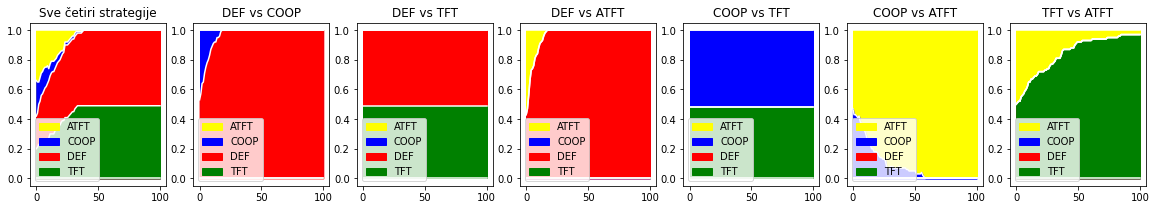

In [12]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(3)
plot_strategy_ratio(game_1, 1, 7, 1, 'Sve četiri strategije')
plot_strategy_ratio(game_2, 1, 7, 2, 'DEF vs COOP')
plot_strategy_ratio(game_3, 1, 7, 3, 'DEF vs TFT')
plot_strategy_ratio(game_4, 1, 7, 4, 'DEF vs ATFT')
plot_strategy_ratio(game_5, 1, 7, 5, 'COOP vs TFT')
plot_strategy_ratio(game_6, 1, 7, 6, 'COOP vs ATFT')
plot_strategy_ratio(game_7, 1, 7, 7, 'TFT vs ATFT')
plt.show()

Rezultate svakih od igara sa različitim strategijama možemo videti gore.
    
    1. U ovoj igri, imali smo sve četiri strategije, i kao što možemo da vidimo, ATFT i COOP su maltene odmah izgubili od DEF (što ima i smisla, jer će DEF zlopotrebiti COOP, a i ATFT će izgubiti od DEF, zato što će na njegove Defect, ATFT odgovarati sa Cooperate). (TFT i DEF sa Jekićem proveriti)
    2. Ovde tačno možemo da vidimo okolnosti opisane u 1. slučaju. COOP izgubi od DEF zbog gore navedenog razloga.
    3. DEF vs TFT (Jekic)
    4. Opet, ovo smo mogli da vidimo u slučaju 1., DEF je zloupotrebio to što ATFT uvek baca suprotno od njega, i osvojio je celu mapu vrlo brzo.
    5. Trenutna okolnost je možda najbolji slučaj u kome COOP može da se nađe. Naime, TFT će da kažemo, "ponavljati ono što protivnik kaže", samim tim, se TFT-ovi ponašaju kao COOP, i sve je stabilno.
    6. COOP će vrlo brzo gubiti protiv ATFT-a, jer se ATFT u ovoj okolnosti ponaša kao DEF.
    7. Andrija!

In [14]:
def plot_strategy_matrix(game, iteration):
    strategy_matrix = game.strategy_matrix_at_instance(iteration)
    
    n = len(strategy_matrix)
    
    data = np.zeros(shape=(n, n))
    
    for i in range(n):
        for j in range(n):
            if strategy_matrix[i][j] == TypeOfStrategy.Cooperator:
                data[i][j] = 2
            elif strategy_matrix[i][j] == TypeOfStrategy.Defactor:
                data[i][j] = 7
            elif strategy_matrix[i][j] == TypeOfStrategy.Tit_for_tat:
                data[i][j] = 12
            elif strategy_matrix[i][j] == TypeOfStrategy.Anti_tit_for_tat:
                data[i][j] = 17
    
    cmap = colors.ListedColormap(['blue', 'red', 'green', 'yellow'])
    bounds = [0, 5, 10, 15, 20]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots()
    
    ax.set_title(f'Stanje u iteraciji {iteration}')
    ax.imshow(data, cmap=cmap, norm=norm)
    
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, n, 1))
    ax.set_yticks(np.arange(-0.5, n, 1))
        
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    plt.show()

In [15]:
import gudhi

In [16]:
def barcode_generator(game_strategy_matrix, wanted_strategy):
    point_cloud = []
    n = len(game_strategy_matrix)
    for i in range(n):
        for j in range(n):
            if game_strategy_matrix[i][j] == wanted_strategy:
                point_cloud.append([i + 1, j + 1])
   
    rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=n * n)
    simplex_tree  = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    
    gudhi.plot_persistence_barcode(diag)
    plt.show()    

## Izbrisao bih i ovo, jer sam stavio sliku ovog slučaja gore

In [18]:
initial_state_case_1 = [
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'D', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'D', 'D', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'D', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
]

game_case_1 = Game(payoff_values, n=10, initial_state=initial_state_case_1, num_of_iterations=25)
game_case_1.play_game()

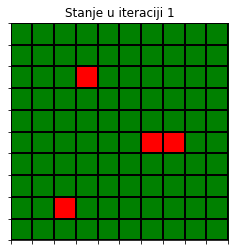

In [19]:
# ispisuje prvu iteraciju! (iteracije pocinju od 1!)
plot_strategy_matrix(game_case_1, 1) 

usetex mode requires dvipng.


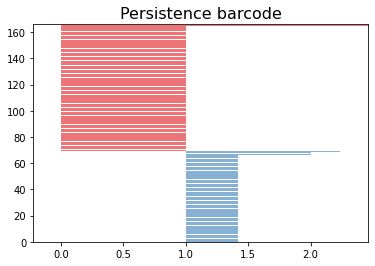

In [20]:
barcode_generator(game_case_1.strategy_matrix_at_instance(1), TypeOfStrategy.Tit_for_tat)

## Case (1) 
##### No mutation, no death of old age

In [21]:
initial_state_case_1 = [
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['D', 'D', 'D', 'D', 'T', 'T', 'T'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
]

game_case_1 = Game(payoff_values, n=7, initial_state=initial_state_case_1, num_of_iterations=25)
game_case_1.play_game()

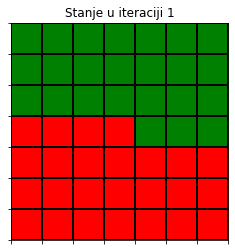

In [22]:
# ispisuje prvu iteraciju! (iteracije pocinju od 1!)
plot_strategy_matrix(game_case_1, 1) 

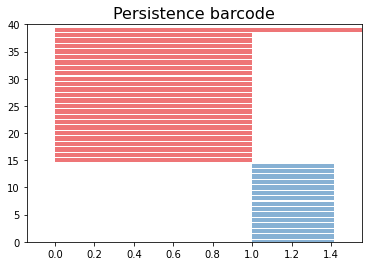

In [23]:
barcode_generator(game_case_1.strategy_matrix_at_instance(1), TypeOfStrategy.Defactor)

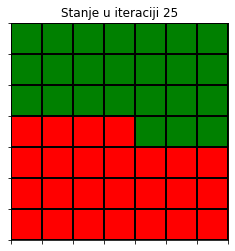

In [24]:
plot_strategy_matrix(game_case_1, 25) 

#### Imamo zamrznuto stanje => nista se ne menja vremenom

## Case (2) 
##### No mutation, no death of old age

In [25]:
initial_state_case_2 = [
    [ 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    [ 'D', 'D', 'D', 'T', 'T', 'T', 'D'],
    [ 'D', 'D', 'D', 'T', 'T', 'T', 'D'],
    [ 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    [ 'D', 'T', 'T', 'T', 'D', 'D', 'D'],
    [ 'D', 'T', 'T', 'T', 'D', 'D', 'D'],
    [ 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
]

game_case_2 = Game(payoff_values, n=7, initial_state=initial_state_case_2, num_of_iterations=1000)
game_case_2.play_game()

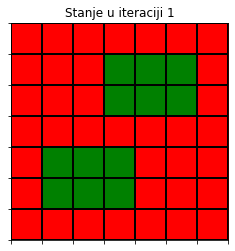

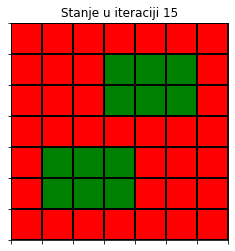

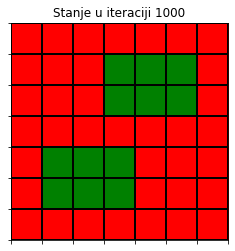

In [26]:
plot_strategy_matrix(game_case_2, 1)
plot_strategy_matrix(game_case_2, 15)
plot_strategy_matrix(game_case_2, 1000)

In [27]:
game_case_2.score_matrix()

[[2, 2, 2, 2, 4, 4, 2],
 [2, 2, 4, 2, 3, 1, 4],
 [2, 2, 2, 3, 1, 2, 2],
 [2, 2, 4, 4, 2, 2, 2],
 [4, 2, 3, 3, 2, 2, 2],
 [2, 3, 2, 2, 2, 2, 2],
 [4, 2, 2, 4, 2, 2, 2]]

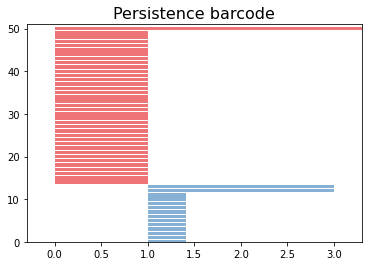

In [28]:
barcode_generator(game_case_2.strategy_matrix_at_instance(15), TypeOfStrategy.Defactor)

##  With mutation, and death of old age

In [29]:
random.seed(42)

In [30]:
initial_state_case_3 =[
    ['A', 'A', 'A', 'A', 'A', 'A', 'A'],
    ['A', 'A', 'A', 'A', 'A', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'C', 'C', 'C', 'C', 'C', 'C'],
    ['C', 'C', 'C', 'C', 'C', 'C', 'C'],
]

# for i in range(7):
#     for j in range(7):
#         prob = random.random()
#         if prob < 0.25:
#             initial_state_case_3[i][j] = 'C'
#         elif prob < 0.5:
#             initial_state_case_3[i][j] = 'D'
#         elif prob < 0.75:
#             initial_state_case_3[i][j] = 'T'
#         else:
#             initial_state_case_3[i][j] = 'A'
            
game_case_3 = Game(payoff_values, n=7, initial_state=None, num_of_iterations=1000, mutation_rate=0.05, rate_of_senescence=20)
game_case_3.play_game()

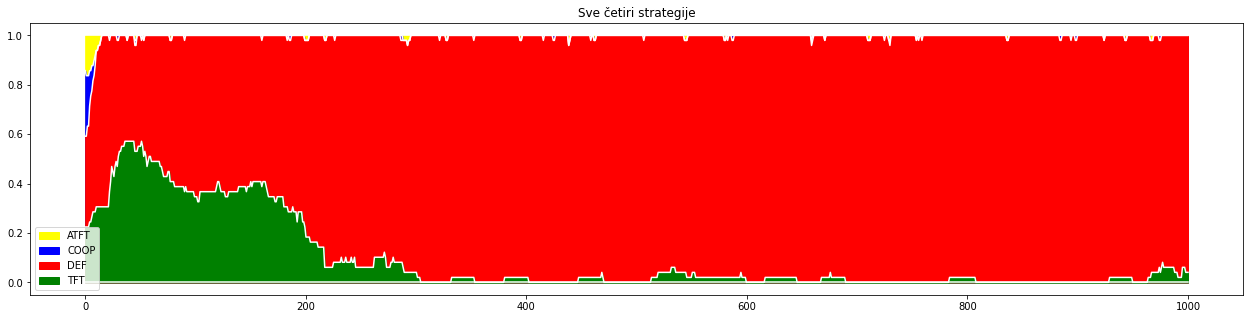

In [31]:
fig = plt.figure()
fig.set_figwidth(100)
fig.set_figheight(5)
plot_strategy_ratio(game_case_3, 1, 4, 1, 'Sve četiri strategije')
plt.show()

In [32]:
def barcode_generator_over(game, start_iter, end_iter, wanted_strategy):
    point_cloud = []
    
    n = len(game.strategy_matrix_at_instance(1))
    for iteration in range(start_iter, end_iter + 1):
        game_strategy_matrix = game.strategy_matrix_at_instance(iteration)
        for i in range(n):
            for j in range(n):
                if game_strategy_matrix[i][j] == wanted_strategy:
                    point_cloud.append([i + 1, j + 1, iteration])
    
    rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=n * n * (end_iter - start_iter))
    simplex_tree  = rips_complex.create_simplex_tree(max_dimension=3)
    diag = simplex_tree.persistence()
    
    gudhi.plot_persistence_barcode(diag)
    plt.show()  

## Case (4)

In [ ]:
barcode_generator_over(game_case_3, 727, 733, TypeOfStrategy.Defactor)
for i in range(727, 733):
    plot_strategy_matrix(game_case_3, i)

heheh


## Case (3 + 5)

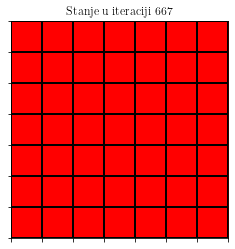

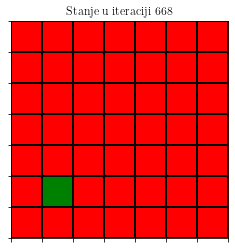

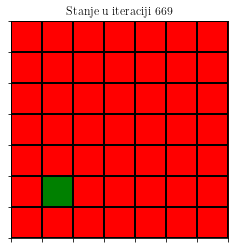

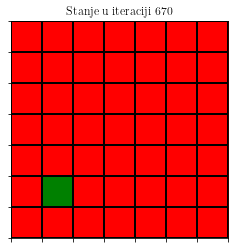

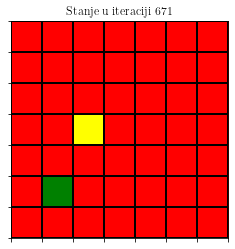

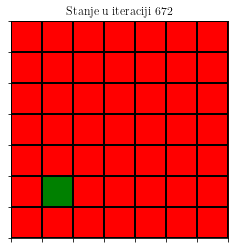

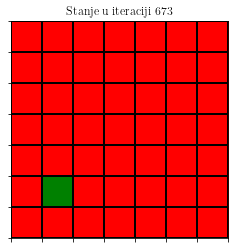

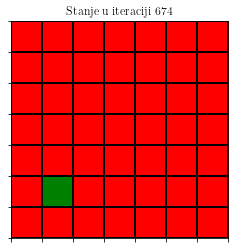

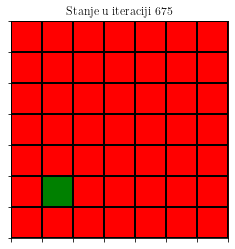

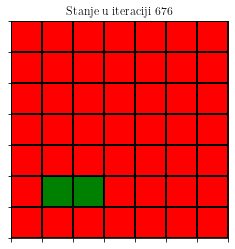

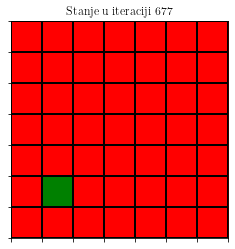

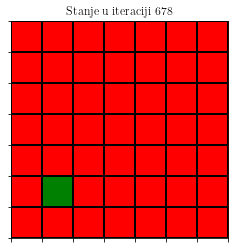

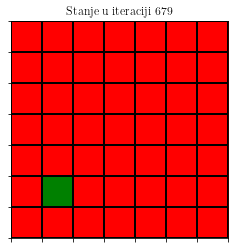

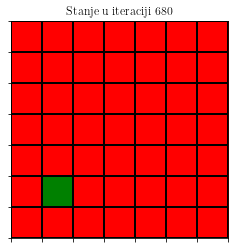

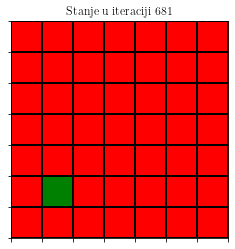

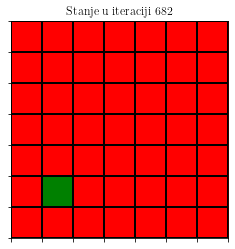

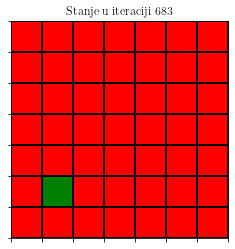

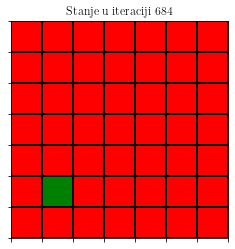

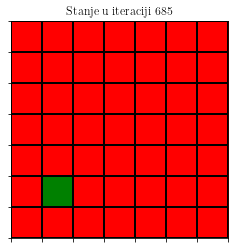

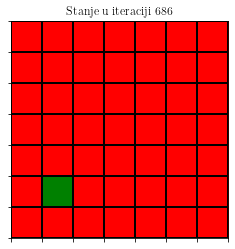

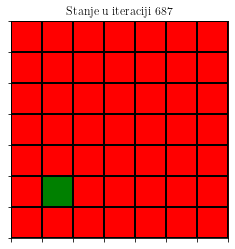

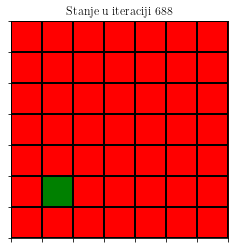

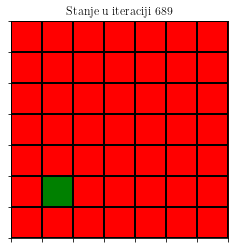

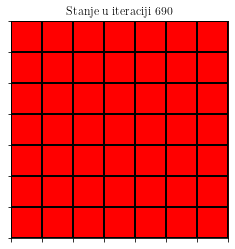

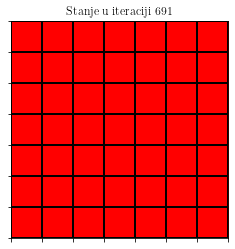

In [56]:
for i in range(667, 692):
    plot_strategy_matrix(game_case_3, i)